<a href="https://colab.research.google.com/github/oneHAMazing/-HAM-PSMDSRC103/blob/main/HAM_Assignment_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7.1 Collecting NYC Temperature Data

HAM NOAA Token: NQMuRQzOUCsZxJWkHCEwvOjBIZuOYFoM

## 7.2 Data Collection through API

In [ ]:
import requests

def make_request(endpoint, payload=None):
  """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.

    Parameters:
    - endpoint: The endpoint of the API you want to
    make a GET request to.
    - payload: A dictionary of data to pass along
    with the request.

    Returns:
    Response object.
  """

  return requests.get(
      f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
      headers={
          'token': 'NQMuRQzOUCsZxJWkHCEwvOjBIZuOYFoM'
          },
      params=payload)

In [ ]:
#see what datasets are available
response = make_request('datasets',{'startdate': '2019-10-01'}) #used pair 1 date
response.status_code

#200 output means 'OK'

200

In [ ]:
#get the keys of the result
#the result is a JSON object which can be accessed with json() method. JSON objects can be treated like disctionaries.

response.json().keys()

dict_keys(['metadata', 'results'])

In [ ]:
response.json()['metadata']

{'resultset': {'offset': 1, 'count': 11, 'limit': 25}}

In [ ]:
#figure out what data is in the result
#the results key contains the requested data
#this is a list of what would be rows in our dataframe

response.json()['results'][0].keys()

dict_keys(['uid', 'mindate', 'maxdate', 'name', 'datacoverage', 'id'])

In [ ]:
#parse the result
#take only the id and name fields

[(data['id'], data['name']) for data in response.json()['results']]

[('GHCND', 'Daily Summaries'),
 ('GSOM', 'Global Summary of the Month'),
 ('GSOY', 'Global Summary of the Year'),
 ('NEXRAD2', 'Weather Radar (Level II)'),
 ('NEXRAD3', 'Weather Radar (Level III)'),
 ('NORMAL_ANN', 'Normals Annual/Seasonal'),
 ('NORMAL_DLY', 'Normals Daily'),
 ('NORMAL_HLY', 'Normals Hourly'),
 ('NORMAL_MLY', 'Normals Monthly'),
 ('PRECIP_15', 'Precipitation 15 Minute'),
 ('PRECIP_HLY', 'Precipitation Hourly')]

In [ ]:
#figure out which data category we want
#the GHCND data containing daily summaries is what we want
#make another request to figure out which data categories we want to collect
#pass the datasetid for GHCND as the payload so the API knows which dataset to get

#get data category id
response = make_request(
    'datacategories',
    payload={
        'datasetid':'GHCND'
    }
)
response.status_code

200

In [ ]:
#NOTE: API gives us a metadata and a results key in each response

response.json()['results']

[{'name': 'Evaporation', 'id': 'EVAP'},
 {'name': 'Land', 'id': 'LAND'},
 {'name': 'Precipitation', 'id': 'PRCP'},
 {'name': 'Sky cover & clouds', 'id': 'SKY'},
 {'name': 'Sunshine', 'id': 'SUN'},
 {'name': 'Air Temperature', 'id': 'TEMP'},
 {'name': 'Water', 'id': 'WATER'},
 {'name': 'Wind', 'id': 'WIND'},
 {'name': 'Weather Type', 'id': 'WXTYPE'}]

In [ ]:
#Grab the data type ID for the Temperature category
#get datatypes to collect for TEMP data category
#specify a limit for the number of datatypes to return with the payload

#get data type id
response = make_request(
    'datatypes',
    payload={
        'datacategoryid': 'TEMP',
        'limit':100
    }
)
response.status_code

200

In [ ]:
#parse result again
#take name and id fields again
#get the bottom

[(datatype['id'], datatype['name']) for datatype in response.json()['results']][-5:] #-5 to get the last 5

[('MNTM', 'Monthly mean temperature'),
 ('TAVG', 'Average Temperature.'),
 ('TMAX', 'Maximum temperature'),
 ('TMIN', 'Minimum temperature'),
 ('TOBS', 'Temperature at the time of observation')]

In [ ]:
#determine which location category we want
#find the location to use
#figure out the location category
#obtained from the locationcategories endpoint by passing the datasetid

#get location category id
response = make_request(
    'locationcategories',
    {
        'datasetid':'GHCND'
    }
)
response.status_code

200

In [ ]:
#use pprint to print dictionaries in an easier-to-read format
#CITY is needed

import pprint
pprint.pprint(response.json())

{'metadata': {'resultset': {'count': 12, 'limit': 25, 'offset': 1}},
 'results': [{'id': 'CITY', 'name': 'City'},
             {'id': 'CLIM_DIV', 'name': 'Climate Division'},
             {'id': 'CLIM_REG', 'name': 'Climate Region'},
             {'id': 'CNTRY', 'name': 'Country'},
             {'id': 'CNTY', 'name': 'County'},
             {'id': 'HYD_ACC', 'name': 'Hydrologic Accounting Unit'},
             {'id': 'HYD_CAT', 'name': 'Hydrologic Cataloging Unit'},
             {'id': 'HYD_REG', 'name': 'Hydrologic Region'},
             {'id': 'HYD_SUB', 'name': 'Hydrologic Subregion'},
             {'id': 'ST', 'name': 'State'},
             {'id': 'US_TERR', 'name': 'US Territory'},
             {'id': 'ZIP', 'name': 'Zip Code'}]}


In [ ]:
#get NYC location ID
#seach through all the cities available
#ask the API to return the cities sorted

def get_item(name, what, endpoint, start=1, end=None):
  """
  Grab the JSON payload for a given field by name using binary search.
  Parameters:
    - name: the item to look for
    - what: Dictionary specifying what the item in 'name' is
    - endpoint: where to look for the item
    - start: the position to start at. we don't need to touch this, but the function will manipulate this with recursion.
    - end: The last position of the cities. Used to find the midpoint, but like 'start' this is not something we need to worry about.
  Returns:
    Dictionary of the information for the item if found otherwise an empty dictionary.
  """
  #find the midpoint which we use to cut the data in half each time
  mid = (start + (end if end else 1)) // 2

  #lowercase the name so this is not case-sensitive
  name = name.lower()

  #define the payload we will send with each request
  payload = {
      'datasetid': 'GHCND',
      'sortfield': 'name',
      'offset': mid, #we will change the offset each time
      'limit' : 1 #we only want one value back
  }

  #make our request adding any additional filter parameters from 'what'
  response = make_request(endpoint, {**payload, **what})

  if response.ok:
    #if response is ok, grab the end index from the response metadata the first time through
    end = end if end else response.json()['metadata']['resultset']['count']

    #grab the lowercase version of the current name
    current_name = response.json()['results'][0]['name'].lower()

    #if what we are searching for is in the current name, we have found our item
    if name in current_name:
      return response.json()['results'][0] #return the found item
    else:
      if start >= end:
        #if our start index is greater than or equal to our end, we couldn't find it
        return {}
      elif name < current_name:
        #our name comes before the current name in the alphabet, so we search further to the left
        return get_item(name, what, endpoint, start, mid - 1)
      elif name > current_name:
        #our name comes after the current name in the alphabet, so we search further to the right
        return get_item(name, what, endpoint, mid + 1, end)
  else:
    #response wasn't ok, use code to determine why
    print(f'Response not OK, status: {response.status_code}')

def get_location(name):
  """
  Grab the JSON payload for the location by name using binary search.
  Parameters:
    - name: the city to look for
  Returns:
    Dictionary of the information for the city if found otherwise an empty dictionary.
  """
  return get_item(name, {'locationcategoryid':'CITY'}, 'locations')

In [ ]:
#get NYC id
nyc = get_location('New York')
nyc

{'mindate': '1869-01-01',
 'maxdate': '2025-04-21',
 'name': 'New York, NY US',
 'datacoverage': 1,
 'id': 'CITY:US360019'}

In [ ]:
#get the station ID for Central Park
central_park = get_item('NY City Central Park', {'locationid':nyc['id']},'stations')
central_park

{'elevation': 42.7,
 'mindate': '1869-01-01',
 'maxdate': '2025-04-20',
 'latitude': 40.77898,
 'name': 'NY CITY CENTRAL PARK, NY US',
 'datacoverage': 1,
 'id': 'GHCND:USW00094728',
 'elevationUnit': 'METERS',
 'longitude': -73.96925}

In [ ]:
#request the temperature data

#get NYC daily summaries data
response = make_request(
    'data',
    {
        'datasetid': 'GHCND',
        'stationid': central_park['id'],
        'locationid': nyc['id'],
        'startdate': '2019-10-01',
        'enddate': '2019-10-31',
        'datatypeid': ['TMIN', 'TMAX', 'TOBS'], #time of observation, min, and max
        'units': 'metric',
        'limit':1000
    }
)
response.status_code

200

In [ ]:
#create a dataframe

import pandas as pd

df = pd.DataFrame(response.json()['results'])
df.head()

,date,datatype,station,attributes,value
0,2019-10-01T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",27.2
1,2019-10-01T00:00:00,TMIN,GHCND:USW00094728,",,W,2400",17.2
2,2019-10-02T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",33.9
3,2019-10-02T00:00:00,TMIN,GHCND:USW00094728,",,W,2400",17.2
4,2019-10-03T00:00:00,TMAX,GHCND:USW00094728,",,W,2400",17.2


In [ ]:
df.datatype.unique()

array(['TMAX', 'TMIN'], dtype=object)

In [ ]:
if get_item(
    'NY City Central Park', {'locationid':nyc['id'], 'datatypeid':'TOBS'}, 'stations'
):
  print('Found!')

Found!


In [ ]:
#use a different station
#use LaGuardia

laguardia = get_item(
    'LaGuardia', {'locationid': nyc['id']}, 'stations'
)
laguardia

{'elevation': 3,
 'mindate': '1939-10-07',
 'maxdate': '2025-04-21',
 'latitude': 40.77945,
 'name': 'LAGUARDIA AIRPORT, NY US',
 'datacoverage': 1,
 'id': 'GHCND:USW00014732',
 'elevationUnit': 'METERS',
 'longitude': -73.88027}

In [ ]:
#get NYC daily summaries data round 2
response = make_request(
    'data',
    {
        'datasetid': 'GHCND',
        'stationid': laguardia['id'],
        'locationid': nyc['id'],
        'startdate': '2019-10-01',
        'enddate': '2019-10-31',
        'datatypeid': ['TMIN', 'TMAX', 'TAVG'], #average daily temperature, min, and max
        'units': 'metric',
        'limit':1000
    }
)
response.status_code

200

In [ ]:
df = pd.DataFrame(response.json()['results'])
df.head()

,date,datatype,station,attributes,value
0,2019-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.3
1,2019-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",27.8
2,2019-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",17.8
3,2019-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",26.9
4,2019-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",35.0


In [ ]:
df.datatype.value_counts()

,count
datatype,
TAVG,31
TMAX,31
TMIN,31


In [ ]:
df.to_csv('/content/sample_data/nyc_temperatures.csv', index=False)

##7.3 Cleaning Data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/sample_data/nyc_temperatures.csv')
df.head()

,date,datatype,station,attributes,value
0,2019-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.3
1,2019-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",27.8
2,2019-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",17.8
3,2019-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",26.9
4,2019-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",35.0


In [ ]:
#check what are the existing columns
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

In [ ]:
#rename value column to indicate it contains the temp in celsius
#rename attributes column to say flags
#pass inplace=True to change the og dataframe

df.rename(
    columns={
        'value':'temp_C',
        'attributes':'flags'
    }, inplace=True
)

In [ ]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

In [ ]:
df.rename(str.upper, axis = 'columns').columns

Index(['DATE', 'DATATYPE', 'STATION', 'FLAGS', 'TEMP_C'], dtype='object')

In [ ]:
df.dtypes

,0
date,object
datatype,object
station,object
flags,object
temp_C,float64


In [ ]:
#typeconversion
#convert to date using pd.to_datetime()

df.loc[: , "date"] = pd.to_datetime(df.date) #did not work
df.dtypes

,0
date,object
datatype,object
station,object
flags,object
temp_C,float64


In [ ]:
df['date'] = pd.to_datetime(df['date']) #i used a different way for it to work
df.dtypes

,0
date,datetime64[ns]
datatype,object
station,object
flags,object
temp_C,float64


In [ ]:
df.date.describe()

,date
count,93
mean,2019-10-16 00:00:00
min,2019-10-01 00:00:00
25%,2019-10-08 00:00:00
50%,2019-10-16 00:00:00
75%,2019-10-24 00:00:00
max,2019-10-31 00:00:00


In [ ]:
pd.date_range(start='2019-10-25', periods=2, freq='D').tz_localize('EST')

DatetimeIndex(['2019-10-25 00:00:00-05:00', '2019-10-26 00:00:00-05:00'], dtype='datetime64[ns, EST]', freq=None)

In [ ]:
eastern = pd.read_csv(
    '/content/sample_data/nyc_temperatures.csv', index_col='date', parse_dates=True
).tz_localize('EST')
eastern.head()

,datatype,station,attributes,value
date,,,,
2019-10-01 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",21.3
2019-10-01 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",27.8
2019-10-01 00:00:00-05:00,TMIN,GHCND:USW00014732,",,W,2400",17.8
2019-10-02 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",26.9
2019-10-02 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",35.0


In [ ]:
eastern.tz_convert('UTC').head()

,datatype,station,attributes,value
date,,,,
2019-10-01 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",21.3
2019-10-01 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",27.8
2019-10-01 05:00:00+00:00,TMIN,GHCND:USW00014732,",,W,2400",17.8
2019-10-02 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",26.9
2019-10-02 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",35.0


In [ ]:
eastern.to_period('M').index

<ipython-input-51-34a82283fe40>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  eastern.to_period('M').index


PeriodIndex(['2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-

In [ ]:
eastern.to_period('M').to_timestamp().index

<ipython-input-52-22abc5f95bfc>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  eastern.to_period('M').to_timestamp().index


DatetimeIndex(['2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
               '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01',
      

In [ ]:
#use assign() method for working with multiple columns at once.

df = pd.read_csv('/content/sample_data/nyc_temperatures.csv').rename(
    columns = {
        'value': 'temp_C',
        'attributes': 'flags'
    }
)

new_df = df.assign(
    date = pd.to_datetime(df.date), #bakit dito gumana?
    temp_F = (df.temp_C * 9/5) + 32
)
new_df.dtypes

,0
date,datetime64[ns]
datatype,object
station,object
flags,object
temp_C,float64
temp_F,float64


In [ ]:
new_df.head()

,date,datatype,station,flags,temp_C,temp_F
0,2019-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.3,70.34
1,2019-10-01,TMAX,GHCND:USW00014732,",,W,2400",27.8,82.04
2,2019-10-01,TMIN,GHCND:USW00014732,",,W,2400",17.8,64.04
3,2019-10-02,TAVG,GHCND:USW00014732,"H,,S,",26.9,80.42
4,2019-10-02,TMAX,GHCND:USW00014732,",,W,2400",35.0,95.00


In [ ]:
#astype() can also be used to perform conversions.

df = df.assign(
    date = pd.to_datetime(df.date),
    temp_C_whole = df.temp_C.astype('int'),
    temp_F = (df.temp_C * 9/5) +32,
    temp_F_whole = lambda x: x.temp_F.astype('int')
)
df.head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2019-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
1,2019-10-01,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
2,2019-10-01,TMIN,GHCND:USW00014732,",,W,2400",17.8,17,64.04,64
3,2019-10-02,TAVG,GHCND:USW00014732,"H,,S,",26.9,26,80.42,80
4,2019-10-02,TMAX,GHCND:USW00014732,",,W,2400",35.0,35,95.00,95


In [ ]:
#creating categories
df_with_categories = df.assign(
    station=df.station.astype('category'),
    datatype=df.datatype.astype('category')
)
df_with_categories.dtypes

,0
date,datetime64[ns]
datatype,category
station,category
flags,object
temp_C,float64
temp_C_whole,int64
temp_F,float64
temp_F_whole,int64


In [ ]:
#categories can be ordered, this is something pandas supports

pd.Categorical(
    ['med', 'med', 'low', 'high'],
    categories=['low','med','high'],
    ordered=True
)

['med', 'med', 'low', 'high']
Categories (3, object): ['low' < 'med' < 'high']

In [ ]:
#reordering, reindexing, and sorting
#sort values buy the temp_C column with the larget on top

df.sort_values(by='temp_C', ascending = False).head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
4,2019-10-02,TMAX,GHCND:USW00014732,",,W,2400",35.0,35,95.00,95
1,2019-10-01,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
3,2019-10-02,TAVG,GHCND:USW00014732,"H,,S,",26.9,26,80.42,80
19,2019-10-07,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
40,2019-10-14,TMAX,GHCND:USW00014732,",,W,2400",23.9,23,75.02,75


In [ ]:
df.sort_values(by=['temp_C', 'date'], ascending = False).head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
4,2019-10-02,TMAX,GHCND:USW00014732,",,W,2400",35.0,35,95.00,95
1,2019-10-01,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
3,2019-10-02,TAVG,GHCND:USW00014732,"H,,S,",26.9,26,80.42,80
19,2019-10-07,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
40,2019-10-14,TMAX,GHCND:USW00014732,",,W,2400",23.9,23,75.02,75


In [ ]:
#nlargest() can be used when just looking for the n-largest values

df.nlargest(n=5, columns='temp_C')

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
4,2019-10-02,TMAX,GHCND:USW00014732,",,W,2400",35.0,35,95.00,95
1,2019-10-01,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
3,2019-10-02,TAVG,GHCND:USW00014732,"H,,S,",26.9,26,80.42,80
19,2019-10-07,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
40,2019-10-14,TMAX,GHCND:USW00014732,",,W,2400",23.9,23,75.02,75


In [ ]:
#nsmallest() is used for the n-smallest values
#these can also take a list of colummns except it won't work with the date column

df.nsmallest(n=5, columns=['temp_C', 'date'])

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
14,2019-10-05,TMIN,GHCND:USW00014732,",,W,2400",7.8,7,46.04,46
56,2019-10-19,TMIN,GHCND:USW00014732,",,W,2400",8.3,8,46.94,46
53,2019-10-18,TMIN,GHCND:USW00014732,",,W,2400",9.4,9,48.92,48
11,2019-10-04,TMIN,GHCND:USW00014732,",,W,2400",10.0,10,50.00,50
59,2019-10-20,TMIN,GHCND:USW00014732,",,W,2400",10.6,10,51.08,51


In [ ]:
#sample() method will give rows (or columns with axis=1) at random
#provide the random_state to make this reproducible
#the index is jumbled after this

df.sample(5, random_state=0).index

Index([2, 30, 55, 16, 13], dtype='int64')

In [ ]:
#use sort_index to sort it
df.sort_index(axis=1).head()

,datatype,date,flags,station,temp_C,temp_C_whole,temp_F,temp_F_whole
0,TAVG,2019-10-01,"H,,S,",GHCND:USW00014732,21.3,21,70.34,70
1,TMAX,2019-10-01,",,W,2400",GHCND:USW00014732,27.8,27,82.04,82
2,TMIN,2019-10-01,",,W,2400",GHCND:USW00014732,17.8,17,64.04,64
3,TAVG,2019-10-02,"H,,S,",GHCND:USW00014732,26.9,26,80.42,80
4,TMAX,2019-10-02,",,W,2400",GHCND:USW00014732,35.0,35,95.00,95


In [ ]:
#this can make selection with loc easier for many columns
#how?

df.sort_index(axis=1).head().loc[:,'temp_C':'temp_F_whole']

,temp_C,temp_C_whole,temp_F,temp_F_whole
0,21.3,21,70.34,70
1,27.8,27,82.04,82
2,17.8,17,64.04,64
3,26.9,26,80.42,80
4,35.0,35,95.00,95


In [ ]:
#sort the index to compare two dataframes
#if the index is different, but the data is the same, they will be marked not equal

df.equals(df.sort_values(by='temp_C'))

False

In [ ]:
#sorting the index solves this issue

df.equals(df.sort_values(by='temp_C').sort_index())

True

In [ ]:
#use reset_index() to get a fresh index and move our current index into a column for safe keeping
#useful if we had data in the index we do not want to lose

df[df.datatype == 'TAVG'].head().reset_index()

,index,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,0,2019-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
1,3,2019-10-02,TAVG,GHCND:USW00014732,"H,,S,",26.9,26,80.42,80
2,6,2019-10-03,TAVG,GHCND:USW00014732,"H,,S,",16.2,16,61.16,61
3,9,2019-10-04,TAVG,GHCND:USW00014732,"H,,S,",16.2,16,61.16,61
4,12,2019-10-05,TAVG,GHCND:USW00014732,"H,,S,",11.8,11,53.24,53


In [ ]:
#set date column as index

df.set_index('date', inplace=True)
df.head()

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2019-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
2019-10-01,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
2019-10-01,TMIN,GHCND:USW00014732,",,W,2400",17.8,17,64.04,64
2019-10-02,TAVG,GHCND:USW00014732,"H,,S,",26.9,26,80.42,80
2019-10-02,TMAX,GHCND:USW00014732,",,W,2400",35.0,35,95.00,95


In [ ]:
#now that we have a DatetimeIndex, we can do datetime slicing
#as long as we provide a date format that pandas understands, we can grab the data

df['2019-10-11':'2019-10-12']

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2019-10-11,TAVG,GHCND:USW00014732,"H,,S,",15.8,15,60.44,60
2019-10-11,TMAX,GHCND:USW00014732,",,W,2400",18.9,18,66.02,66
2019-10-11,TMIN,GHCND:USW00014732,",,W,2400",12.8,12,55.04,55
2019-10-12,TAVG,GHCND:USW00014732,"H,,S,",15.8,15,60.44,60
2019-10-12,TMAX,GHCND:USW00014732,",,W,2400",20.6,20,69.08,69
2019-10-12,TMIN,GHCND:USW00014732,",,W,2400",13.3,13,55.94,55


In [ ]:
sp = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/sp500.csv', index_col = 'date', parse_dates=True
).drop(columns = ['adj_close'])

sp.head(10).assign(
    day_of_week = lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000,Friday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000,Monday
2017-01-10,2279.270020,2265.270020,2269.719971,2268.899902,3638790000,Tuesday
2017-01-11,2275.320068,2260.830078,2268.600098,2275.320068,3620410000,Wednesday
2017-01-12,2271.780029,2254.250000,2271.139893,2270.439941,3462130000,Thursday
2017-01-13,2278.679932,2271.510010,2272.739990,2274.639893,3081270000,Friday


In [ ]:
bitcoin = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/bitcoin.csv', index_col='date', parse_dates=True
).drop(columns=['market_cap'])

#every day's closing price = S&P 500 close + Bitcoin close (same for other metrics)
portfolio = pd.concat(
    [sp, bitcoin], sort=False
).groupby(pd.Grouper(freq='D')).sum()

portfolio.head(10).assign(
    day_of_week = lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,1003.080000,958.700000,963.660000,998.330000,147775008,Sunday
2017-01-02,1031.390000,996.700000,998.620000,1021.750000,222184992,Monday
2017-01-03,3307.959883,3266.729883,3273.170068,3301.670078,3955698000,Tuesday
2017-01-04,3432.240068,3306.000098,3306.000098,3425.480000,4109835984,Wednesday
2017-01-05,3462.600000,3170.869951,3424.909932,3282.380000,4272019008,Thursday
2017-01-06,3328.910098,3148.000059,3285.379893,3179.179980,3691766000,Friday
2017-01-07,908.590000,823.560000,903.490000,908.590000,279550016,Saturday
2017-01-08,942.720000,887.250000,908.170000,911.200000,158715008,Sunday
2017-01-09,3189.179990,3148.709902,3186.830088,3171.729902,3359486992,Monday


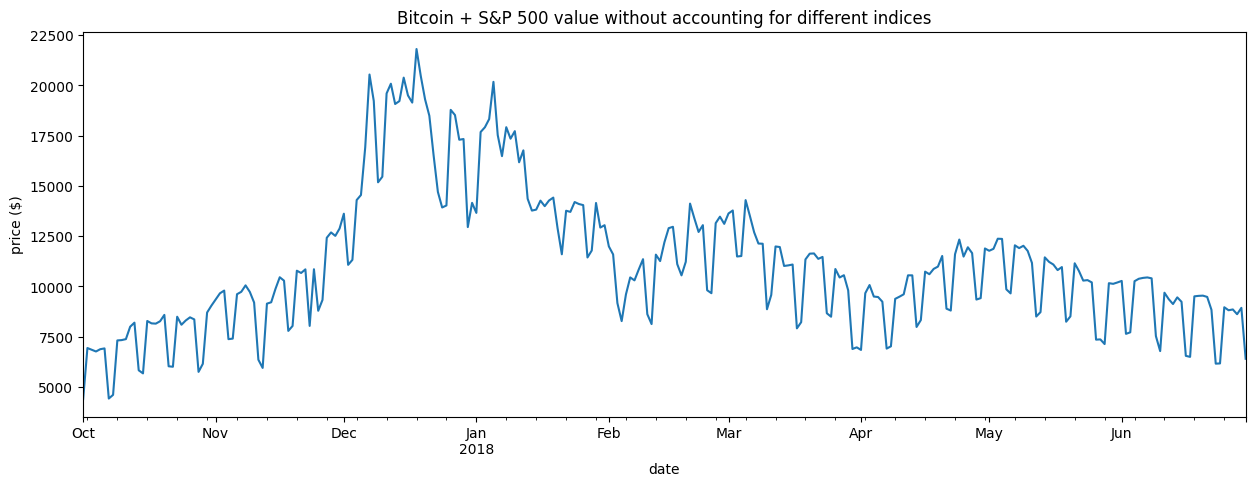

In [ ]:
import matplotlib.pyplot as plt #use this module for plotting

portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', figsize=(15,5), legend=False,
    title = 'Bitcoin + S&P 500 value without accounting for different indices'
)#plot the closing price from Q4 2017 through Q2 2018
plt.ylabel('price ($)') #yaxis label
plt.show() # show the plot

In [ ]:
sp.reindex(bitcoin.index).head(10).assign(
    day_of_week = lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,NaN,NaN,NaN,NaN,NaN,Saturday
2017-01-08,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


In [ ]:
sp.reindex(
    bitcoin.index, method='ffill'
).head(10).assign(
    day_of_week = lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Saturday
2017-01-08,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


In [ ]:
import numpy as np

sp_reindexed = sp.reindex(
    bitcoin.index
).assign(
    volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
    close=lambda x: x.close.fillna(method='ffill'), # carry this forward
    # take the closing price if these aren't available
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
)
sp_reindexed.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

<ipython-input-78-66e2f40a9155>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close=lambda x: x.close.fillna(method='ffill'), # carry this forward


,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,0.000000e+00,Sunday
2017-01-02,NaN,NaN,NaN,NaN,0.000000e+00,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Saturday
2017-01-08,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


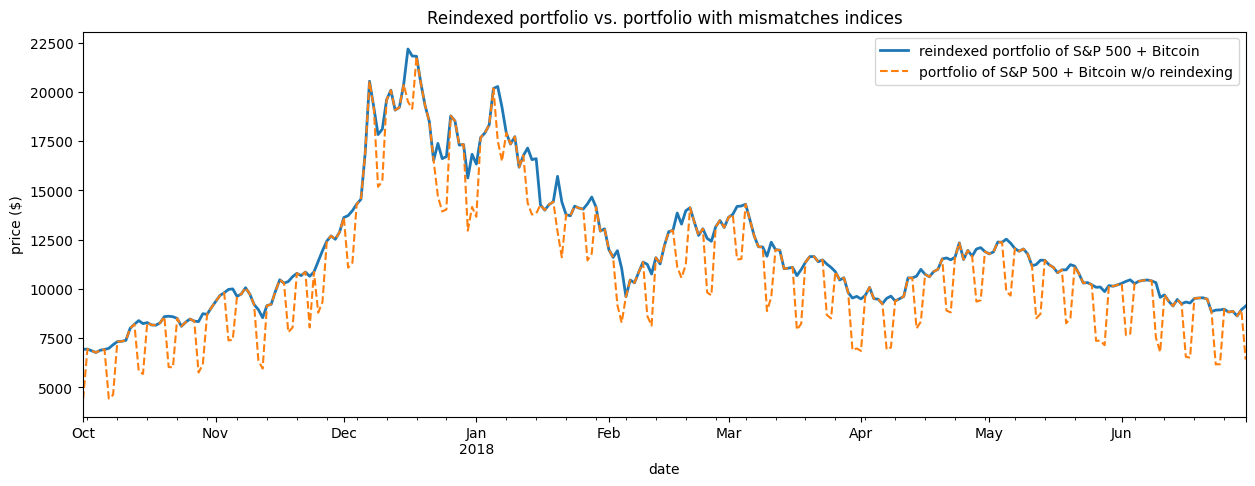

In [ ]:
# every day's closing price = S&P 500 close adjusted for market closure + Bitcoin close (same for other metrics)
fixed_portfolio = pd.concat([sp_reindexed, bitcoin], sort=False).groupby(pd.Grouper(freq='D')).sum()

ax = fixed_portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', label='reindexed portfolio of S&P 500 + Bitcoin', figsize=(15, 5), linewidth=2,
    title='Reindexed portfolio vs. portfolio with mismatches indices'
) # plot the reindexed portfolio's closing price from Q4 2017 through Q2 2018

portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', ax=ax, linestyle='--', label='portfolio of S&P 500 + Bitcoin w/o reindexing'
).set_ylabel('price ($)') # add line for original portfolio for comparison and label y-axis

plt.show() # show the plot

## 7.4 Reshaping Data

In [ ]:
#get data to start

import pandas as pd

long_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/long_data.csv',
    usecols = ['date','datatype','value']
).rename(
    columns = {
        'value': 'temp_C'
    }
  ).assign(
      date = lambda x: pd.to_datetime(x.date),
      temp_F = lambda x: (x.temp_C * 9/5) + 32
  )
long_df.head()

,datatype,date,temp_C,temp_F
0,TMAX,2018-10-01,21.1,69.98
1,TMIN,2018-10-01,8.9,48.02
2,TOBS,2018-10-01,13.9,57.02
3,TMAX,2018-10-02,23.9,75.02
4,TMIN,2018-10-02,13.9,57.02


In [ ]:
#Transposing swaps the rows and the columns.
#use the T attribute to do so

long_df.head().T

,0,1,2,3,4
datatype,TMAX,TMIN,TOBS,TMAX,TMIN
date,2018-10-01 00:00:00,2018-10-01 00:00:00,2018-10-01 00:00:00,2018-10-02 00:00:00,2018-10-02 00:00:00
temp_C,21.1,8.9,13.9,23.9,13.9
temp_F,69.98,48.02,57.02,75.02,57.02


In [ ]:
#Pivoting is going from long to wide format
#We can restructure our data by picking a column to go in the index ( index ), a column whose unique values will become column names ( columns ), and the values to place in those columns ( values ). The pivot() method can be used when we don't need to perform any aggregation in addition to our restructuring (when our index is unique); if this is not the case, we need the pivot_table() method which we will cover in future modules.

pivoted_df = long_df.pivot(
    index = 'date', columns = 'datatype', values = 'temp_C'
)
pivoted_df.head()

datatype,TMAX,TMIN,TOBS
date,,,
2018-10-01,21.1,8.9,13.9
2018-10-02,23.9,13.9,17.2
2018-10-03,25.0,15.6,16.1
2018-10-04,22.8,11.7,11.7
2018-10-05,23.3,11.7,18.9


In [ ]:
#pd.pivot() function yields equivalent results

pd.pivot_table(
    index = long_df.date, columns = long_df.datatype, values = long_df.temp_C
).head()

#i copied this directly from the slides.seems to be wrong

TypeError: pivot_table() missing 1 required positional argument: 'data'

In [ ]:
#pd.pivot() function yields equivalent results
#i changed the code to actually work.

pd.pivot_table(
    long_df, index = 'date', columns = 'datatype', values = 'temp_C'
).head()

datatype,TMAX,TMIN,TOBS
date,,,
2018-10-01,21.1,8.9,13.9
2018-10-02,23.9,13.9,17.2
2018-10-03,25.0,15.6,16.1
2018-10-04,22.8,11.7,11.7
2018-10-05,23.3,11.7,18.9


In [ ]:
pivoted_df.describe()

datatype,TMAX,TMIN,TOBS
count,31.000000,31.000000,31.000000
mean,16.829032,7.561290,10.022581
std,5.714962,6.513252,6.596550
min,7.800000,-1.100000,-1.100000
25%,12.750000,2.500000,5.550000
50%,16.100000,6.700000,8.300000
75%,21.950000,13.600000,16.100000
max,26.700000,17.800000,21.700000


In [ ]:
pivoted_df = long_df.pivot(
    index = 'date', columns = 'datatype', values = ['temp_C','temp_F']
)
pivoted_df.head()

temp_C             temp_F              
datatype     TMAX  TMIN  TOBS   TMAX   TMIN   TOBS
date                                              
2018-10-01   21.1   8.9  13.9  69.98  48.02  57.02
2018-10-02   23.9  13.9  17.2  75.02  57.02  62.96
2018-10-03   25.0  15.6  16.1  77.00  60.08  60.98
2018-10-04   22.8  11.7  11.7  73.04  53.06  53.06
2018-10-05   23.3  11.7  18.9  73.94  53.06  66.02

In [ ]:
pivoted_df['temp_F']['TMIN'].head()

,TMIN
date,
2018-10-01,48.02
2018-10-02,57.02
2018-10-03,60.08
2018-10-04,53.06
2018-10-05,53.06


In [ ]:
#unstack()
#we can create an index from any number of columns with set_index()
#this gives us MultiIndex where the outermost level corresponsds to the first element in the list provided to set_index()

multi_index_df = long_df.set_index(['date','datatype'])
multi_index_df.index

#parang iba yung output

MultiIndex([('2018-10-01', 'TMAX'),
            ('2018-10-01', 'TMIN'),
            ('2018-10-01', 'TOBS'),
            ('2018-10-02', 'TMAX'),
            ('2018-10-02', 'TMIN'),
            ('2018-10-02', 'TOBS'),
            ('2018-10-03', 'TMAX'),
            ('2018-10-03', 'TMIN'),
            ('2018-10-03', 'TOBS'),
            ('2018-10-04', 'TMAX'),
            ('2018-10-04', 'TMIN'),
            ('2018-10-04', 'TOBS'),
            ('2018-10-05', 'TMAX'),
            ('2018-10-05', 'TMIN'),
            ('2018-10-05', 'TOBS'),
            ('2018-10-06', 'TMAX'),
            ('2018-10-06', 'TMIN'),
            ('2018-10-06', 'TOBS'),
            ('2018-10-07', 'TMAX'),
            ('2018-10-07', 'TMIN'),
            ('2018-10-07', 'TOBS'),
            ('2018-10-08', 'TMAX'),
            ('2018-10-08', 'TMIN'),
            ('2018-10-08', 'TOBS'),
            ('2018-10-09', 'TMAX'),
            ('2018-10-09', 'TMIN'),
            ('2018-10-09', 'TOBS'),
            ('2018-10-10', '

In [ ]:
multi_index_df.head()

temp_C  temp_F
date       datatype                
2018-10-01 TMAX        21.1   69.98
           TMIN         8.9   48.02
           TOBS        13.9   57.02
2018-10-02 TMAX        23.9   75.02
           TMIN        13.9   57.02

In [ ]:
#With the MultiIndex , we can no longer use pivot() . We must now use unstack() , which by default moves the innermost index onto the columns

unstacked_df = multi_index_df.unstack()
unstacked_df.head()

temp_C             temp_F              
datatype     TMAX  TMIN  TOBS   TMAX   TMIN   TOBS
date                                              
2018-10-01   21.1   8.9  13.9  69.98  48.02  57.02
2018-10-02   23.9  13.9  17.2  75.02  57.02  62.96
2018-10-03   25.0  15.6  16.1  77.00  60.08  60.98
2018-10-04   22.8  11.7  11.7  73.04  53.06  53.06
2018-10-05   23.3  11.7  18.9  73.94  53.06  66.02

In [ ]:
#The unstack() method also provides the fill_value parameter, which let's us fill-in any NaN values that might arise from this restructuring of the data. Consider the case that we have data for the average temperature on October 1, 2018, but no other date

extra_data = long_df.append(
    [{'datatype':'TAVG', 'date':'2018-10-01', 'temp_C':10, 'temp_F':50}]
).set_index(['date','datatype']).sort_index()

extra_data.head(8)

#this gives out an error since 'DataFrame' object has no attribute 'append'

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
#this is how i added the new row to the data
add_data = pd.DataFrame({
    'date': pd.to_datetime(['2018-10-01']),
    'datatype':['TAVG'],
    'temp_C': [10],
    'temp_F': [50]
})

extra_data = pd.concat([long_df,add_data], ignore_index=True).set_index( ['date','datatype']).sort_index()
extra_data.head(8)


temp_C  temp_F
date       datatype                
2018-10-01 TAVG        10.0   50.00
           TMAX        21.1   69.98
           TMIN         8.9   48.02
           TOBS        13.9   57.02
2018-10-02 TMAX        23.9   75.02
           TMIN        13.9   57.02
           TOBS        17.2   62.96
2018-10-03 TMAX        25.0   77.00

In [ ]:
extra_data.unstack().head()

temp_C                   temp_F                     
datatype     TAVG  TMAX  TMIN  TOBS   TAVG   TMAX   TMIN   TOBS
date                                                           
2018-10-01   10.0  21.1   8.9  13.9   50.0  69.98  48.02  57.02
2018-10-02    NaN  23.9  13.9  17.2    NaN  75.02  57.02  62.96
2018-10-03    NaN  25.0  15.6  16.1    NaN  77.00  60.08  60.98
2018-10-04    NaN  22.8  11.7  11.7    NaN  73.04  53.06  53.06
2018-10-05    NaN  23.3  11.7  18.9    NaN  73.94  53.06  66.02

In [ ]:
extra_data.unstack(fill_value=-40).head()

temp_C                   temp_F                     
datatype     TAVG  TMAX  TMIN  TOBS   TAVG   TMAX   TMIN   TOBS
date                                                           
2018-10-01   10.0  21.1   8.9  13.9   50.0  69.98  48.02  57.02
2018-10-02  -40.0  23.9  13.9  17.2  -40.0  75.02  57.02  62.96
2018-10-03  -40.0  25.0  15.6  16.1  -40.0  77.00  60.08  60.98
2018-10-04  -40.0  22.8  11.7  11.7  -40.0  73.04  53.06  53.06
2018-10-05  -40.0  23.3  11.7  18.9  -40.0  73.94  53.06  66.02

In [ ]:
#melting
#from wide to long format

wide_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/wide_data.csv')
wide_df.head()

,date,TMAX,TMIN,TOBS
0,2018-10-01,21.1,8.9,13.9
1,2018-10-02,23.9,13.9,17.2
2,2018-10-03,25.0,15.6,16.1
3,2018-10-04,22.8,11.7,11.7
4,2018-10-05,23.3,11.7,18.9


melt() </br>
In order to go from wide format to long format, we use the melt() method.</br> We have to specify:</br>
which column contains the unique identifier for each row ( date , here) to id_vars </br>
the column(s) that contain the values ( TMAX , TMIN , and TOBS , here) to value_vars</br>
Optionally, we can also provide:</br>
value_name : what to call the column that will contain all the values once melted</br>
var_name : what to call the column that will contain the names of the variables being measured</br>

In [ ]:
melted_df = wide_df.melt(
    id_vars='date',
    value_vars=['TMAX', 'TMIN', 'TOBS'],
    value_name='temp_C',
    var_name='measurement'
)
melted_df.head()

,date,measurement,temp_C
0,2018-10-01,TMAX,21.1
1,2018-10-02,TMAX,23.9
2,2018-10-03,TMAX,25.0
3,2018-10-04,TMAX,22.8
4,2018-10-05,TMAX,23.3


In [ ]:
#just as we also had pd.pivot() there is a pd.melt()

pd.melt(
    wide_df,
    id_vars='date',
    value_vars=['TMAX', 'TMIN', 'TOBS'],
    value_name='temp_C',
    var_name='measurement'
).head()

,date,measurement,temp_C
0,2018-10-01,TMAX,21.1
1,2018-10-02,TMAX,23.9
2,2018-10-03,TMAX,25.0
3,2018-10-04,TMAX,22.8
4,2018-10-05,TMAX,23.3


stack() </br>
Another option is stack() which will pivot the columns of the dataframe into the innermost level of a MultiIndex . To illustrate this, let's set our index to be the date
column

In [ ]:
wide_df.set_index('date', inplace=True)
wide_df.head()

,TMAX,TMIN,TOBS
date,,,
2018-10-01,21.1,8.9,13.9
2018-10-02,23.9,13.9,17.2
2018-10-03,25.0,15.6,16.1
2018-10-04,22.8,11.7,11.7
2018-10-05,23.3,11.7,18.9


In [ ]:
stacked_series = wide_df.stack()
stacked_series.head()

date            
2018-10-01  TMAX    21.1
            TMIN     8.9
            TOBS    13.9
2018-10-02  TMAX    23.9
            TMIN    13.9
dtype: float64

In [ ]:
stacked_df = stacked_series.to_frame('values')
stacked_df.head()

values
date                   
2018-10-01 TMAX    21.1
           TMIN     8.9
           TOBS    13.9
2018-10-02 TMAX    23.9
           TMIN    13.9

In [ ]:
stacked_df.index
#parang iba na naman yung itsura ng output

MultiIndex([('2018-10-01', 'TMAX'),
            ('2018-10-01', 'TMIN'),
            ('2018-10-01', 'TOBS'),
            ('2018-10-02', 'TMAX'),
            ('2018-10-02', 'TMIN'),
            ('2018-10-02', 'TOBS'),
            ('2018-10-03', 'TMAX'),
            ('2018-10-03', 'TMIN'),
            ('2018-10-03', 'TOBS'),
            ('2018-10-04', 'TMAX'),
            ('2018-10-04', 'TMIN'),
            ('2018-10-04', 'TOBS'),
            ('2018-10-05', 'TMAX'),
            ('2018-10-05', 'TMIN'),
            ('2018-10-05', 'TOBS'),
            ('2018-10-06', 'TMAX'),
            ('2018-10-06', 'TMIN'),
            ('2018-10-06', 'TOBS'),
            ('2018-10-07', 'TMAX'),
            ('2018-10-07', 'TMIN'),
            ('2018-10-07', 'TOBS'),
            ('2018-10-08', 'TMAX'),
            ('2018-10-08', 'TMIN'),
            ('2018-10-08', 'TOBS'),
            ('2018-10-09', 'TMAX'),
            ('2018-10-09', 'TMIN'),
            ('2018-10-09', 'TOBS'),
            ('2018-10-10', '

In [ ]:
stacked_df.index.names

FrozenList(['date', None])

In [ ]:
stacked_df.index.rename(['date','datatype'], inplace=True)
stacked_df.index.names

FrozenList(['date', 'datatype'])

##7.5 Handling Missing Data

In [ ]:
#handling duplicate, missing, or invalid data

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dirty_data.csv')
df.head()

,date,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
0,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
1,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
3,2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
4,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False


In [ ]:
df.describe()

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF
count,765.000000,577.000000,577.0,765.000000,765.000000,398.000000,11.000000
mean,5.360392,4.202773,NaN,2649.175294,-15.914379,8.632161,16.290909
std,10.002138,25.086077,NaN,2744.156281,24.242849,9.815054,9.489832
min,0.000000,0.000000,-inf,-11.700000,-40.000000,-16.100000,1.800000
25%,0.000000,0.000000,NaN,13.300000,-40.000000,0.150000,8.600000
50%,0.000000,0.000000,NaN,32.800000,-11.100000,8.300000,19.300000
75%,5.800000,0.000000,NaN,5505.000000,6.700000,18.300000,24.900000
max,61.700000,229.000000,inf,5505.000000,23.900000,26.100000,28.700000


In [ ]:
#the info() method can pinpoint missing values and wrong data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               765 non-null    object 
 1   station            765 non-null    object 
 2   PRCP               765 non-null    float64
 3   SNOW               577 non-null    float64
 4   SNWD               577 non-null    float64
 5   TMAX               765 non-null    float64
 6   TMIN               765 non-null    float64
 7   TOBS               398 non-null    float64
 8   WESF               11 non-null     float64
 9   inclement_weather  408 non-null    object 
dtypes: float64(7), object(3)
memory usage: 59.9+ KB


In [ ]:
#we can use pd.isnull() or pd.isna() or the isna() or isnull() method of the series to find nulls

contain_nulls = df[
    df.SNOW.isnull() | df.SNWD.isna()\
    | pd.isnull(df.TOBS) | pd.isna(df.WESF)\
    | df.inclement_weather.isna()
]
contain_nulls.shape[0]

765

In [ ]:
contain_nulls.head(10)

,date,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
0,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
1,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
3,2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
4,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
5,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
6,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
7,2018-01-04T00:00:00,?,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True
8,2018-01-04T00:00:00,?,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True
9,2018-01-05T00:00:00,?,0.3,NaN,NaN,5505.0,-40.0,NaN,NaN,NaN


In [ ]:
#we want to check for nulls?
#this doesn't work

df[df.inclement_weather == 'NaN'].shape[0]

0

In [ ]:
#another way to check for nulls?
#this also doesn't work

import numpy as np
df[df.inclement_weather == np.nan].shape[0]

0

In [ ]:
#a way to check that works

df[df.inclement_weather.isna()].shape[0]

357

In [ ]:
#another way to check

df[df.SNWD.isin([-np.inf, np.inf])].shape[0]

577

In [ ]:
#instead of checking for each column, we can write a fxn that will use a dictionary comprehension to check all the columns for us

import numpy as np

def get_inf_count(df):
  """find the number of inf/-inf values per column in the dataframe"""
  return{
      col : df[df[col].isin([np.inf, -np.inf])].shape[0] for col in df.columns
  }

get_inf_count(df)

{'date': 0,
 'station': 0,
 'PRCP': 0,
 'SNOW': 0,
 'SNWD': 577,
 'TMAX': 0,
 'TMIN': 0,
 'TOBS': 0,
 'WESF': 0,
 'inclement_weather': 0}

In [ ]:
pd.DataFrame({
    'np.inf Snow Depth': df[df.SNWD == np.inf].SNOW.describe(),
    '-np.inf Snow Depth': df[df.SNWD == -np.inf].SNOW.describe()
}).T

,count,mean,std,min,25%,50%,75%,max
np.inf Snow Depth,24.0,101.041667,74.498018,13.0,25.0,120.5,152.0,229.0
-np.inf Snow Depth,553.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.describe(include='object')

,date,station,inclement_weather
count,765,765,408
unique,324,2,2
top,2018-07-05T00:00:00,GHCND:USC00280907,False
freq,8,398,384


In [ ]:
#use the duplicated() method to find duplicate rows

df[df.duplicated()].shape[0]

284

In [ ]:
#The default for keep is 'first' meaning it won't show the first row that the duplicated data was seen in; we can pass in False to see it though

df[df.duplicated(keep=False)].shape[0]

482

In [ ]:
df[df.duplicated(['date','station'])].shape[0]

284

In [ ]:
df[df.duplicated()].head()

,date,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
1,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
5,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
6,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
8,2018-01-04T00:00:00,?,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True


In [ ]:
df[df.WESF.notna()].station.unique()

array(['?'], dtype=object)

In [ ]:
#save this information for later
station_qm_wesf = df[df.station == '?'].WESF

#sort ? to the bottom
df.sort_values('station', ascending=False, inplace = True)

#drop duplicates based on the date column keeping the first occurrence
#which will be the valid station if it has data
df_deduped = df.drop_duplicates('date').drop(
    #remove the station column because we are done with it
    #and WESF because we need to replace it later
    columns = ['station','WESF']
).sort_values('date').assign( #sort by the date
    #add back the WESF column which will be properly matched because of the index
    WESF = station_qm_wesf
)
df_deduped.shape

(324, 9)

In [ ]:
df_deduped.head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,NaN
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,NaN
8,2018-01-04T00:00:00,20.6,229.0,inf,5505.0,-40.0,NaN,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,NaN


In [ ]:
#dealing with nulls
#We could drop nulls, replace them with some arbitrary value, or impute them using the surrounding data. Each of these options may have ramifications, so we must choose wisely
#sa true

#We can use dropna() to drop rows where any column has a null value. The default options leave us without data
df_deduped.dropna().shape

(0, 9)

In [ ]:
#if we pass how='all' we can choose to only drop rows where everything is null but this removes nothing
df_deduped.dropna(how='all').shape

(324, 9)

In [ ]:
df_deduped.dropna(
    how='all',
    subset=['inclement_weather','SNOW','SNWD']
).shape

(293, 9)

In [ ]:
df_deduped.dropna(axis='columns', thresh=df_deduped.shape[0]*0.75).columns

Index(['date', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS',
       'inclement_weather'],
      dtype='object')

In [ ]:
df_deduped.loc[:,'WESF'].fillna(0, inplace=True)
df_deduped.head()
#bakit may NaN sa workbook sa output ko wala?

<ipython-input-27-d64e5c761ef7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_deduped.loc[:,'WESF'].fillna(0, inplace=True)


,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,5505.0,-40.0,0.0,0,0.0
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,inf,5505.0,-40.0,0.0,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,0.0


In [ ]:
#At this point we have done every we can without distorting the data.
#just because we can do something doesn't mean we should
#preach

#fillna() has 2 options
#ffill to forward fill
#bfill to backward fill

#df_deduped.assign(
#    TMAX=lambda x: x.TMAX.replace(5505, np.nan).fillna(method='ffill'),
#    TMIN=lambda x: x.TMIN.replace(-40, np.nan).fillna(method='ffill')
#).head()

df_deduped.assign(
    TMAX=lambda x: x.TMAX.replace(5505, np.nan).ffill(),
    TMIN=lambda x: x.TMIN.replace(-40, np.nan).ffill()
).head()
#merong error message na mawawala na daw yung fillna so diretsong ffill() or bfill() na lang daw

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,NaN,NaN,0.0,0,0.0
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,inf,-4.4,-13.9,0.0,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,0.0


In [ ]:
#use np.nan_to_num() to turn np.nan into 0 and -np.inf / np.inf into large negative or positive finite numbers

df_deduped.assign(
    SNWD = lambda x: np.nan_to_num(x.SNWD)
).head()

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-1.797693e+308,5505.0,-40.0,0.0,0,0.0
3,2018-01-02T00:00:00,0.0,0.0,-1.797693e+308,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-1.797693e+308,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,1.797693e+308,5505.0,-40.0,0.0,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,1.797693e+308,-4.4,-13.9,-13.9,True,0.0


In [ ]:
#We can couple fillna() with other types of calculations for interpolation. Here we replace missing values of TMAX with the median of all TMAX values, TMIN with the median of all TMIN values, and TOBS to the average of the TMAX and TMIN values. Since we place TOBS last, we have access to the imputed values for TMIN and TMAX in the calculation.

df_deduped.assign(
    TMAX=lambda x: x.TMAX.replace(5505, np.nan).fillna(x.TMAX.median()),
    TMIN=lambda x: x.TMIN.replace(-40, np.nan).fillna(x.TMIN.median()),
    # average of TMAX and TMIN
    TOBS=lambda x: x.TOBS.fillna((x.TMAX + x.TMIN) / 2)
).head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,22.8,0.0,0.0,0,0.0
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,inf,22.8,0.0,0.0,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,0.0


In [ ]:
#We can also use apply() for running the same calculation across columns. For example, let's fill all missing values with their rolling 7 day median of their values, setting the number of periods required for the calculation to 0 to ensure we don't introduce more extra NaN values. We need to set the date column as the index so apply() doesn't try to take the rolling 7 day median of the date

df_deduped.assign(
    # make TMAX and TMIN NaN where appropriate
    TMAX=lambda x: x.TMAX.replace(5505, np.nan),
    TMIN=lambda x: x.TMIN.replace(-40, np.nan)
).set_index('date').apply(
    # rolling calculations will be covered in chapter 4, this is a rolling 7 day median
    # we set min_periods (# of periods required for calculation) to 0 so we always get a result
    lambda x: x.fillna(x.rolling(7, min_periods=0).median())
).head(10)

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
date,,,,,,,,
2018-01-01T00:00:00,0.0,0.0,-inf,NaN,NaN,0.0,0,0.0
2018-01-02T00:00:00,0.0,0.0,-inf,-8.30,-16.1,-12.2,False,0.0
2018-01-03T00:00:00,0.0,0.0,-inf,-4.40,-13.9,-13.3,False,0.0
2018-01-04T00:00:00,20.6,229.0,inf,-6.35,-15.0,0.0,True,19.3
2018-01-05T00:00:00,14.2,127.0,inf,-4.40,-13.9,-13.9,True,0.0
2018-01-06T00:00:00,0.0,0.0,-inf,-10.00,-15.6,-15.0,False,0.0
2018-01-07T00:00:00,0.0,0.0,-inf,-11.70,-17.2,-16.1,False,0.0
2018-01-08T00:00:00,0.0,0.0,-inf,-7.80,-16.7,-8.3,False,0.0
2018-01-10T00:00:00,0.0,0.0,-inf,5.00,-7.8,-7.8,False,0.0


In [ ]:
#The last strategy we could try is interpolation with the interpolate() method. We specify the method parameter with the interpolation strategy to use. There are many options, but we will stick with the default of 'linear' , which will treat values as evenly spaced and place missing values in the middle of existing ones. We have some missing data, so we will reindex first. Look at January 9th, which we didn't have before—the values for TMAX , TMIN , and TOBS are the average of values the day prior (January 8th) and the day after (January 10th)

df_deduped.assign(
    # make TMAX and TMIN NaN where appropriate
    TMAX=lambda x: x.TMAX.replace(5505, np.nan),
    TMIN=lambda x: x.TMIN.replace(-40, np.nan),
    date=lambda x: pd.to_datetime(x.date)
).set_index('date').reindex(
    pd.date_range('2018-01-01', '2018-12-31', freq='D')
).apply(
    lambda x: x.interpolate()
).head(10)

<ipython-input-35-f0f270bc97cb>:11: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  lambda x: x.interpolate()


,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
2018-01-01,0.0,0.0,-inf,NaN,NaN,0.00,0,0.0
2018-01-02,0.0,0.0,-inf,-8.3,-16.10,-12.20,False,0.0
2018-01-03,0.0,0.0,-inf,-4.4,-13.90,-13.30,False,0.0
2018-01-04,20.6,229.0,inf,-4.4,-13.90,0.00,True,19.3
2018-01-05,14.2,127.0,inf,-4.4,-13.90,-13.90,True,0.0
2018-01-06,0.0,0.0,-inf,-10.0,-15.60,-15.00,False,0.0
2018-01-07,0.0,0.0,-inf,-11.7,-17.20,-16.10,False,0.0
2018-01-08,0.0,0.0,-inf,-7.8,-16.70,-8.30,False,0.0
2018-01-09,0.0,0.0,-inf,-1.4,-12.25,-8.05,NaN,0.0
2018-01-10,0.0,0.0,-inf,5.0,-7.80,-7.80,False,0.0
